# User Average Active Time as Metric

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# reading the data sets
t1_user_active_min     = pd.read_csv("t1_user_active_min.csv")
t2_user_variant        = pd.read_csv("t2_user_variant.csv")
t3_user_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
t4_user_attributes     = pd.read_csv("t4_user_attributes.csv")

# Use table 1 and 2

In [3]:
t1_user_active_min.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [4]:
t2_user_variant.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [5]:
# Drop data with active_mins more than (24 hrs * 60 mins) on a single date.
t1_user_active_min = t1_user_active_min[t1_user_active_min.active_mins <= 24*60]

In [6]:
# Total minutes per user
t1_user_active_min_mean = t1_user_active_min.groupby(by=['uid'], as_index=False).mean()

In [21]:
# merge t1 and t2 by uid
t12 = pd.merge(t2_user_variant, t1_user_active_min_mean, on='uid')

In [22]:
t12.head()

,uid,variant_number,dt,signup_date,active_mins
0,0,0,2019-02-06,2018-09-24,3.307692
1,1,0,2019-02-06,2016-11-07,160.052632
2,2,0,2019-02-06,2018-09-17,2.428571
3,3,0,2019-02-06,2018-03-04,3.208333
4,4,0,2019-02-06,2017-03-09,1.950000


In [23]:
t12.variant_number.value_counts()

0    37425
1     9208
Name: variant_number, dtype: int64

# Compute confidence interval on difference of means.

In [24]:
stats12 = t12.groupby(['variant_number'])['active_mins'].agg(['mean', 'count', 'std','var'])
stats12

,mean,count,std,var
variant_number,,,,
0,8.761316,37425,18.780503,352.707296
1,11.638743,9208,21.102090,445.298205


In [25]:
sigma_diff = np.sqrt(stats12.loc[0]['var'] / stats12.loc[0]['count'] + 
                     stats12.loc[1]['var'] / stats12.loc[1]['count'])
upper = (stats12.loc[1]['mean'] - stats12.loc[0]['mean']) + (1.96 * sigma_diff)
lower = (stats12.loc[1]['mean'] - stats12.loc[0]['mean']) - (1.96 * sigma_diff)
print([lower, upper])

[2.406274815429466, 3.3485787569999346]


Perform a t-test:

In [26]:
stats.ttest_ind(t12.active_mins[t12.variant_number==1], t12.active_mins[t12.variant_number==0], equal_var =False)

Ttest_indResult(statistic=11.970143076301513, pvalue=7.574338206129901e-33)

The low p-value suggests strong evidence for the new UI design to make a positive impact on total active time per user.

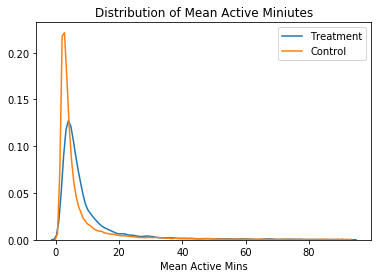

In [116]:
build_dist(t12[(t12.variant_number==1) & 
                (t12.active_mins < t12.active_mins.quantile(0.99)) &
                (t12.active_mins > t12.active_mins.quantile(0.01))], 
           t12[(t12.variant_number==0) & 
                (t12.active_mins < t12.active_mins.quantile(0.99)) & 
                (t12.active_mins > t12.active_mins.quantile(0.01))],
           "active_mins","active_mins","Mean Active Mins", "Treatment","Control",
           title='Distribution of Mean Active Miniutes')

# Add Table 3

In [27]:
t3_user_active_min_pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [28]:
# Drop data with active_mins more than (24 hrs * 60 mins) on a single date.
t3_user_active_min_pre = t3_user_active_min_pre[t3_user_active_min_pre.active_mins <= 24*60]

In [29]:
# Total minutes per user
t3_user_active_min_pre_mean = t3_user_active_min_pre.groupby(by=['uid'], as_index=False).mean()

In [31]:
t123 = pd.merge(t12, t3_user_active_min_pre_mean, on='uid', suffixes=('_post', '_pre'))

In [32]:
t123.head()

,uid,variant_number,dt,signup_date,active_mins_post,active_mins_pre
0,0,0,2019-02-06,2018-09-24,3.307692,3.333333
1,1,0,2019-02-06,2016-11-07,160.052632,158.330579
2,2,0,2019-02-06,2018-09-17,2.428571,3.700000
3,3,0,2019-02-06,2018-03-04,3.208333,5.684211
4,4,0,2019-02-06,2017-03-09,1.950000,2.357143


In [33]:
t123['active_mins_diff'] = t123['active_mins_post'] - t123['active_mins_pre']

In [34]:
stats123 = t123.groupby(['variant_number'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'std','var'])
stats123

active_mins_post                               active_mins_pre  \
                           mean  count        std         var            mean   
variant_number                                                                  
0                      8.778037  37313  18.805182  353.634855        9.114909   
1                     11.668744   9165  21.145444  447.129817        7.221025   

                                             active_mins_diff         \
                count        std         var             mean  count   
variant_number                                                         
0               37313  18.827314  354.467740        -0.336872  37313   
1                9165  12.555481  157.640098         4.447719   9165   

                                       
                      std         var  
variant_number                         
0                9.605306   92.261909  
1               13.110952  171.897057

# Difference in difference

For each user, first obtain difference in post-test user average time and pre-test user average time: $\Delta x_1 \equiv x_{1,post} - x_{1,pre}$ and $\Delta x_2 \equiv x_{0,post} - x_{0,pre}$

Then obtain the difference in mean: $\overline{\Delta x_1} - \overline{\Delta x_2}$ <br>

Standard Error: $\sqrt{\frac{s_{\Delta x_1}^2}{n_1} + \frac{s_{\Delta x_2}^2}{n_1}}$

In [35]:
mean_did = stats123.loc[1,'active_mins_diff']['mean'] - stats123.loc[0,'active_mins_diff']['mean']

sigma_did = np.sqrt(stats123.loc[1,'active_mins_diff']['var'] / stats123.loc[1,'active_mins_diff']['count'] + 
                    stats123.loc[0,'active_mins_diff']['var'] / stats123.loc[0,'active_mins_diff']['count'])

upper = mean_did + (1.96 * sigma_did)
lower = mean_did - (1.96 * sigma_did)
print([lower, upper])

[4.499019292447001, 5.070162945220937]


Perform a t-test:

In [36]:
stats.ttest_ind(t123.active_mins_diff[t123.variant_number==1], t123.active_mins_diff[t123.variant_number==0], equal_var =False)

Ttest_indResult(statistic=32.838668686479814, pvalue=2.6124834427323526e-226)

The low p-value suggests high evidence for the new UI design to make a positive impact on total active time per user.

In [37]:
def build_dist(df1, df2, col1, col2, xlabel, legend1, legend2, title):
    sns.distplot(df1[col1], hist=False, label = legend1, axlabel = xlabel)
    sns.distplot(df2[col2], hist=False, label = legend2, axlabel = xlabel)
    plt.title(title)
    #plt.xlim([-1000,1000])
    plt.show()

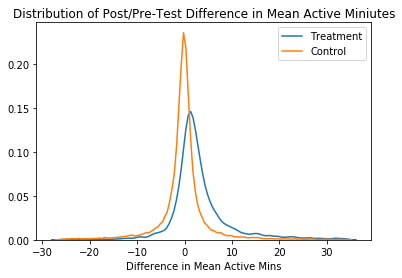

In [111]:
build_dist(t123[(t123.variant_number==1) & 
                (t123.active_mins_diff < t123.active_mins_diff.quantile(0.99)) &
                (t123.active_mins_diff > t123.active_mins_diff.quantile(0.01))], 
           t123[(t123.variant_number==0) & 
                (t123.active_mins_diff < t123.active_mins_diff.quantile(0.99)) & 
                (t123.active_mins_diff > t123.active_mins_diff.quantile(0.01))],
           "active_mins_diff","active_mins_diff","Difference in Mean Active Mins", "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Mean Active Miniutes')

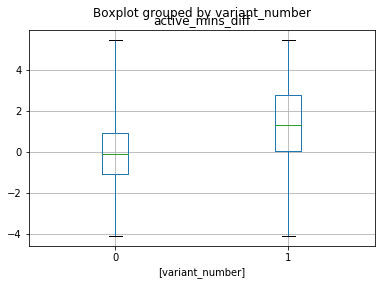

In [49]:
t123[(t123.active_mins_diff < t123.active_mins_diff.quantile(0.9)) &
     (t123.active_mins_diff > t123.active_mins_diff.quantile(0.1))][['variant_number','active_mins_diff']].boxplot(by=['variant_number'],whis='range')

# Add Table 4

In [57]:
t4_user_attributes.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [58]:
t1234 = pd.merge(t4_user_attributes, t123, on='uid')

In [59]:
t1234.head()

,uid,gender,user_type,variant_number,dt,signup_date,active_mins_post,active_mins_pre,active_mins_diff
0,0,male,non_reader,0,2019-02-06,2018-09-24,3.307692,3.333333,-0.025641
1,1,male,reader,0,2019-02-06,2016-11-07,160.052632,158.330579,1.722053
2,2,male,non_reader,0,2019-02-06,2018-09-17,2.428571,3.700000,-1.271429
3,3,male,non_reader,0,2019-02-06,2018-03-04,3.208333,5.684211,-2.475877
4,4,male,non_reader,0,2019-02-06,2017-03-09,1.950000,2.357143,-0.407143


In [60]:
pd.crosstab(t1234['variant_number'],t1234['gender']).apply(lambda r: r/r.sum(), axis=1)

gender,female,male,unknown
variant_number,,,
0,0.286737,0.561493,0.151770
1,0.282815,0.559083,0.158101


In [61]:
pd.crosstab(t1234['variant_number'],t1234['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
variant_number,,,,
0,0.024415,0.061185,0.735240,0.17916
1,0.013857,0.084015,0.764648,0.13748


In [62]:
pd.crosstab(t1234['gender'],t1234['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
gender,,,,
female,0.018734,0.074637,0.745166,0.161463
male,0.025849,0.055801,0.732579,0.185772
unknown,0.016170,0.085208,0.764342,0.134280


# Gender

In [63]:
stats1234_gender = t1234.groupby(['variant_number','gender'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'var'])
stats1234_gender

active_mins_post                    active_mins_pre  \
                                   mean  count         var            mean   
variant_number gender                                                        
0              female          7.642952  10699  234.200195        8.213522   
               male            9.704124  20951  424.230905        9.872825   
               unknown         7.496357   5663  310.960230        8.013876   
1              female         10.590656   2592  325.528234        6.584398   
               male           12.397131   5124  516.836077        7.553167   
               unknown        11.021509   1449  414.340209        7.185305   

                                          active_mins_diff                     
                        count         var             mean  count         var  
variant_number gender                                                          
0              female   10699  265.149126        -0.570570  10699   77.191873  
               male     20951  414.573699        -0.168701  20951   95.450908  
               unknown   5663  296.083171        -0.517519   5663  108.728279  
1              female    2592   97.235650         4.006258   2592  146.060911  
               male      5124  187.825623         4.843964   5124  193.222009  
               unknown   1449  158.030374         3.836204   1449  141.638766

In [64]:
def ConfidenceInterval(stats, attribute):
    mean_did = stats.loc[1, attribute]['active_mins_diff', 'mean'] - stats.loc[0,attribute]['active_mins_diff', 'mean']
    SE_did = np.sqrt(stats.loc[1, attribute]['active_mins_diff','var'] / stats.loc[1, attribute]['active_mins_diff','count'] + 
                     stats.loc[0, attribute]['active_mins_diff','var'] / stats.loc[0, attribute]['active_mins_diff','count'])

    upper = mean_did + (1.96 * SE_did)
    lower = mean_did - (1.96 * SE_did)
    return [lower, upper]

In [65]:
intervals = {}
for g in set(t4_user_attributes['gender']):
    intervals[g] = ConfidenceInterval(stats1234_gender, g)
    print(g, ':', ConfidenceInterval(stats1234_gender, g))

female : [4.082668281657273, 5.070986716879877]
male : [4.609718461419328, 5.415611021626094]
unknown : [3.6834453016973905, 5.023999837578068]


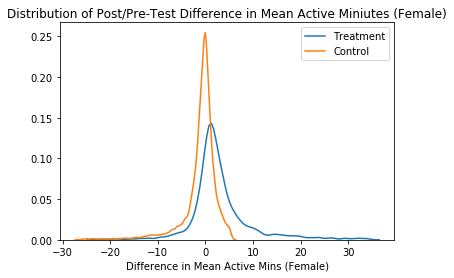

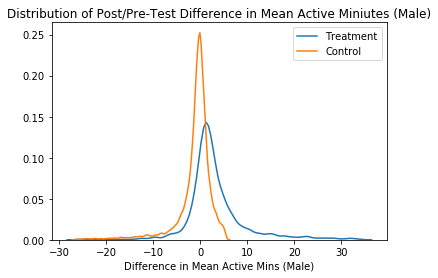

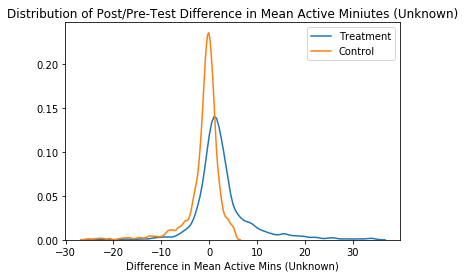

In [112]:
for g in set(t4_user_attributes['gender']):
    build_dist(t1234[(t1234.variant_number==1) & (t1234.gender==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.99)) &
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.01))], 
           t1234[(t1234.variant_number==0) & (t1234.gender==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.90)) & 
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.01))],
           "active_mins_diff","active_mins_diff","Difference in Mean Active Mins " + '(' + g.title() + ')', "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Mean Active Miniutes ' + '(' + g.title() + ')')

# User Type

In [68]:
stats1234_user_type = t1234.groupby(['variant_number','user_type'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'var'])
stats1234_user_type

active_mins_post                      \
                                       mean  count          var   
variant_number user_type                                          
0              contributor        53.160145    911  4151.228369   
               new_user            3.441046   2283    22.749363   
               non_reader          4.447460  27434    29.756430   
               reader             22.324380   6685   740.317113   
1              contributor        65.306837    127  6568.871801   
               new_user            6.242814    770    54.127892   
               non_reader          7.508955   7008    68.836087   
               reader             32.714566   1260  1333.164449   

                           active_mins_pre                      \
                                      mean  count          var   
variant_number user_type                                         
0              contributor       56.656796    911  4184.622372   
               new_user           4.483866   2283    32.671914   
               non_reader         4.555002  27434    25.243865   
               reader            22.930689   6685   702.626548   
1              contributor       44.492685    127  2990.703181   
               new_user           4.698840    770    27.781261   
               non_reader         4.610943   7008    16.323160   
               reader            19.522641   1260   406.913170   

                           active_mins_diff                      
                                       mean  count          var  
variant_number user_type                                         
0              contributor        -3.496651    911  1421.410863  
               new_user           -1.042821   2283    32.017415  
               non_reader         -0.107542  27434    21.984408  
               reader             -0.606310   6685   218.532163  
1              contributor        20.814152    127  1570.721009  
               new_user            1.543974    770    70.745919  
               non_reader          2.898012   7008    55.079299  
               reader             13.191925   1260   622.182256

In [69]:
for g in set(t4_user_attributes['user_type']):
    intervals[g] = ConfidenceInterval(stats1234_user_type, g)
    print(g, ':', ConfidenceInterval(stats1234_user_type, g))

contributor : [16.995995749451346, 31.625610810993443]
non_reader : [2.8231488470903954, 3.1879584027166366]
reader : [12.376071976734565, 15.220396987874775]
new_user : [1.9489593821827849, 3.2246293485292896]


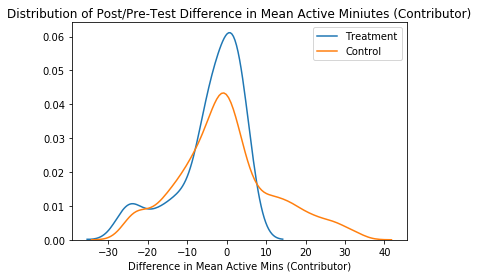

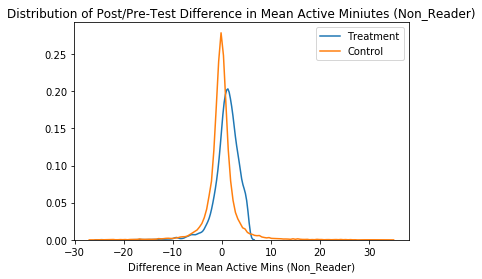

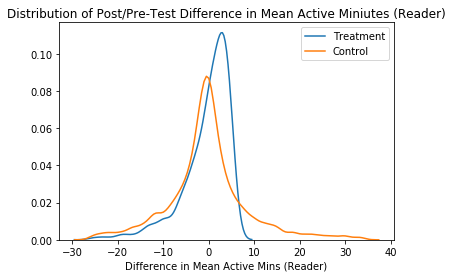

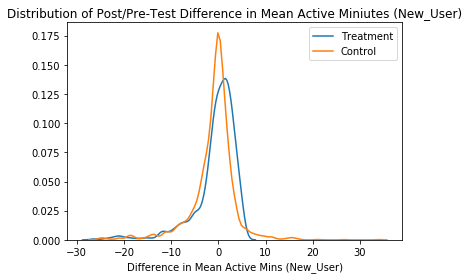

In [113]:
for g in set(t4_user_attributes['user_type']):
    build_dist(t1234[(t1234.variant_number==1) & (t1234.user_type==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.90)) &
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.01))], 
           t1234[(t1234.variant_number==0) & (t1234.user_type==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.99)) & 
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.01))],
           "active_mins_diff","active_mins_diff","Difference in Mean Active Mins " + '(' + g.title() + ')', "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Mean Active Miniutes ' + '(' + g.title() + ')')

# Gender and User Type

In [72]:
stats1234 = t1234.groupby(['variant_number','user_type','gender'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'var'])
stats1234

active_mins_post                      \
                                               mean  count          var   
variant_number user_type   gender                                         
0              contributor female         38.714459    223  2066.235264   
                           male           58.017646    592  4452.855001   
                           unknown        56.761676     96  6584.499784   
               new_user    female          3.306261    732    12.007781   
                           male            3.476038   1090    17.301803   
                           unknown         3.572328    461    52.765472   
               non_reader  female          4.353322   7932    41.899578   
                           male            4.545964  15175    27.172688   
                           unknown         4.274572   4327    16.490376   
               reader      female         19.971238   1812   615.897040   
                           male           23.495545   4094   786.285890   
                           unknown        21.642918    779   769.423072   
1              contributor female         53.337951     26  3460.047432   
                           male           72.437659     82  7224.506929   
                           unknown        50.910186     19  8008.855289   
               new_user    female          6.033502    260    33.294186   
                           male            6.098764    365    38.696240   
                           unknown         6.980743    145   130.679167   
               non_reader  female          7.242834   1972    60.681066   
                           male            7.719148   3927    76.425539   
                           unknown         7.237863   1109    56.219090   
               reader      female         30.576685    334  1262.135957   
                           male           33.391819    750  1364.267695   
                           unknown        33.885655    176  1338.367584   

                                   active_mins_pre                      \
                                              mean  count          var   
variant_number user_type   gender                                        
0              contributor female        46.924005    223  2498.233754   
                           male          59.510130    592  4642.289710   
                           unknown       61.669696     96  5067.883149   
               new_user    female         4.266963    732    23.383233   
                           male           4.591055   1090    31.122791   
                           unknown        4.574837    461    51.131887   
               non_reader  female         4.525700   7932    40.190753   
                           male           4.592553  15175    20.056575   
                           unknown        4.477025   4327    16.035386   
               reader      female        21.187164   1812   655.815328   
                           male          23.673501   4094   711.371701   
                           unknown       23.082419    779   757.384032   
1              contributor female        34.521595     26   892.456079   
                           male          49.235937     82  3690.044221   
                           unknown       37.666457     19  2794.911451   
               new_user    female         4.900733    260    30.799772   
                           male           4.404795    365    22.607230   
                           unknown        5.077011    145    35.380023   
               non_reader  female         4.389482   1972    14.319893   
                           male           4.685607   3927    16.264141   
                           unknown        4.740352   1109    20.001511   
               reader      female        18.679489    334   342.441848   
                           male          19.542601    750   407.295960   
                           unknown       21.037655    176   528.938075   

          

In [73]:
covariates = [[a,b] for a in set(t4_user_attributes['user_type']) for b in set(t4_user_attributes['gender'])]
len(covariates)

12

In [74]:
def ConfidenceInterval_covariate(stats, covariate):
    mean_did = stats.loc[1, covariate[0], covariate[1]]['active_mins_diff', 'mean'] - stats.loc[0, covariate[0], covariate[1]]['active_mins_diff', 'mean']
    SE_did = np.sqrt(stats.loc[1, covariate[0], covariate[1]]['active_mins_diff','var'] / stats.loc[1, covariate[0], covariate[1]]['active_mins_diff','count'] + 
                     stats.loc[0, covariate[0], covariate[1]]['active_mins_diff','var'] / stats.loc[0, covariate[0], covariate[1]]['active_mins_diff','count'])

    upper = mean_did + (1.96 * SE_did)
    lower = mean_did - (1.96 * SE_did)
    return [lower, upper]

In [75]:
for c in covariates:
    intervals['_'.join(c)] = ConfidenceInterval_covariate(stats1234, c)
    print(c, ':', ConfidenceInterval_covariate(stats1234, c))

['contributor', 'female'] : [12.130744823642814, 41.92105855818548]
['contributor', 'male'] : [15.730777970918131, 33.65763474572131]
['contributor', 'unknown'] : [-5.206375673663516, 41.50987221834224]
['non_reader', 'female'] : [2.700530875954784, 3.350930907232195]
['non_reader', 'male'] : [2.8255329034443393, 3.334727150265173]
['non_reader', 'unknown'] : [2.27444359904215, 3.1254824622100603]
['reader', 'female'] : [10.39133884786024, 15.834906003385534]
['reader', 'male'] : [12.112992512053513, 15.941355559229901]
['reader', 'unknown'] : [11.037669873335581, 17.537331735804244]
['new_user', 'female'] : [1.0973757799120127, 3.0895669986213443]
['new_user', 'male'] : [2.033044325735124, 3.584928320328269]
['new_user', 'unknown'] : [0.7886594445558002, 5.023821684977663]


In [76]:
df_intervals = pd.DataFrame(intervals)

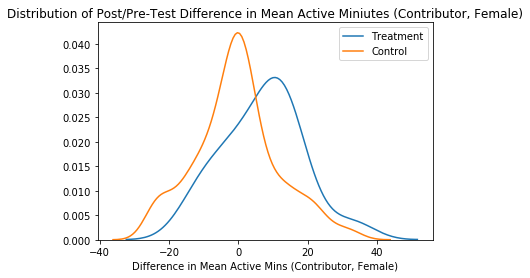

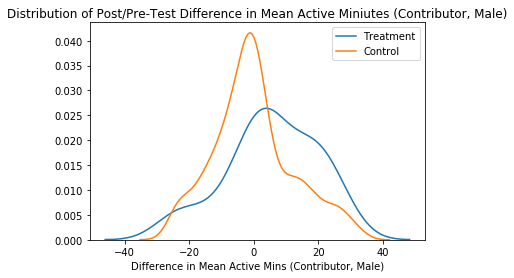

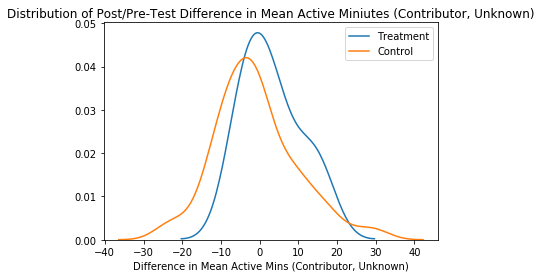

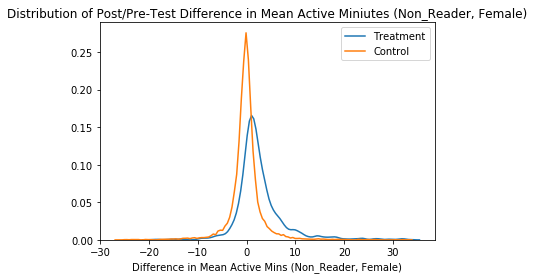

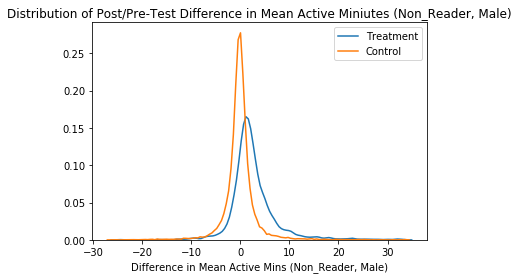

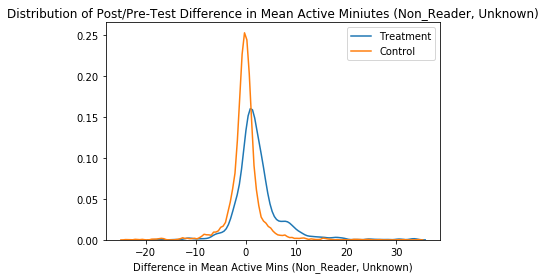

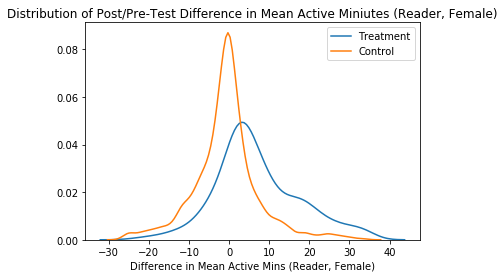

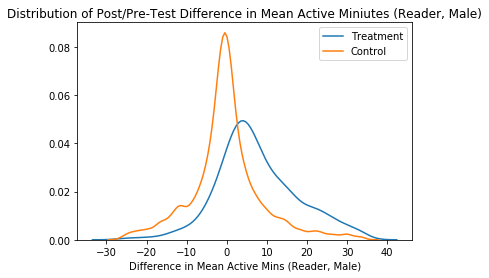

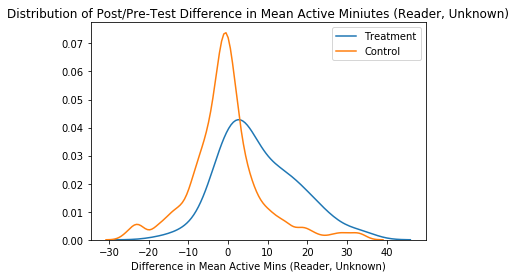

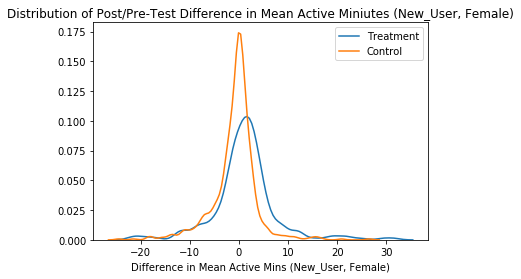

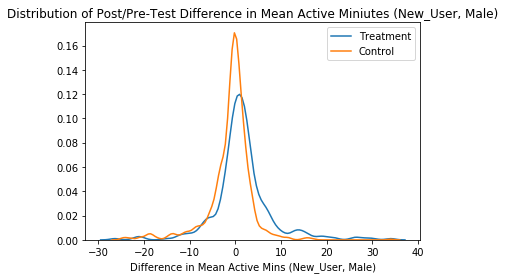

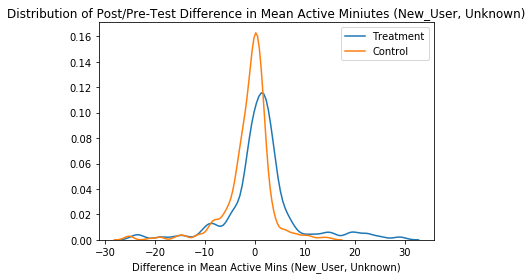

In [114]:
for c in covariates:
    build_dist(t1234[(t1234.variant_number==1) & (t1234.user_type==c[0]) & (t1234.gender==c[1]) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.99)) &
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.01))], 
           t1234[(t1234.variant_number==0) & (t1234.user_type==c[0]) & (t1234.gender==c[1]) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.99)) & 
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.01))],
           "active_mins_diff","active_mins_diff","Difference in Mean Active Mins " + '(' + c[0].title() + ', ' + c[1].title() + ')', "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Mean Active Miniutes ' + '(' + c[0].title() + ', ' + c[1].title() + ')')

(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

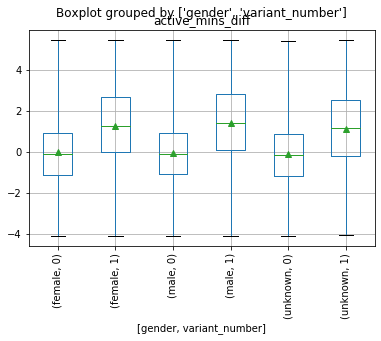

In [103]:
t1234[(t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.9)) &
     (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.1))][['variant_number','gender', 'active_mins_diff']].boxplot(by=['gender', 'variant_number'],whis='range',
                                                                                                                              showmeans=True)
plt.xticks(rotation=90)

(array([1, 2, 3, 4, 5, 6, 7, 8]), <a list of 8 Text xticklabel objects>)

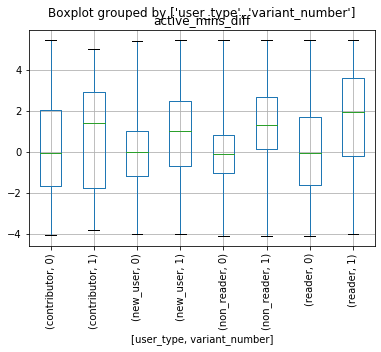

In [104]:
t1234[(t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.9)) &
     (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.1))][['variant_number', 'user_type', 'active_mins_diff']].boxplot(by=['user_type', 'variant_number'], whis='range')
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]), <a list of 24 Text xticklabel objects>)

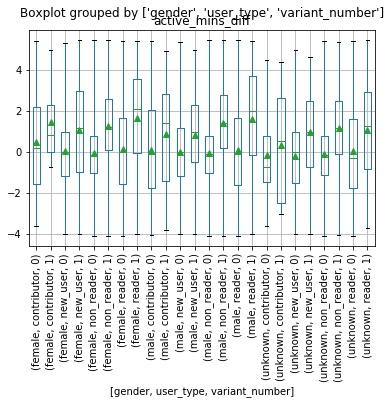

In [105]:
t1234[(t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.9)) &
     (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.1))][['variant_number', 'gender', 'user_type', 'active_mins_diff']].boxplot(by=['gender', 'user_type', 'variant_number'], showmeans=True, whis='range')
plt.xticks(rotation=90)

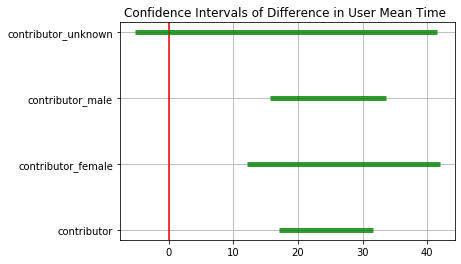

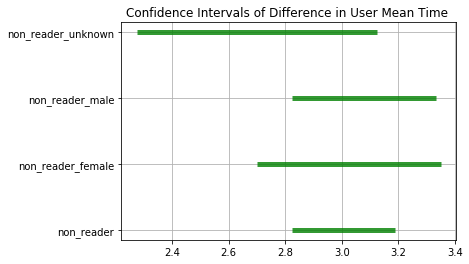

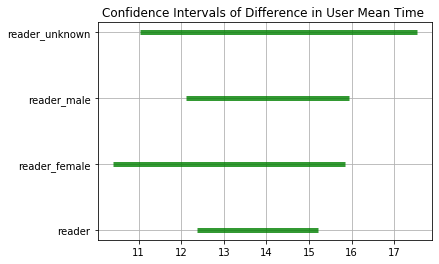

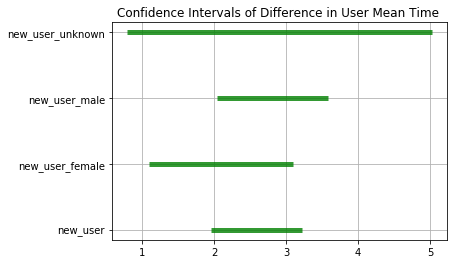

In [107]:
for u in set(t4_user_attributes.user_type):
    plt.figure()
    plt.title('Confidence Intervals of Difference in User Mean Time ')
    plt.grid()
    plt.vlines(0, -1, 4, colors='r')
    for i in df_intervals.columns[df_intervals.columns.str.startswith(u)]:
        plt.hlines(i, df_intervals[i][0], df_intervals[i][1], colors='g', alpha=0.8, linestyles='solid', label=i, linewidth=5.0)